## Classifying customer satisfaction based on relevant factors

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import isnan, when, count, col
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('customer-satisfaction-v1').getOrCreate()
df = spark.read.csv('hdfs://namenode/satisfaction.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- satisfaction_v2: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Onli

Gender: Gender of the passengers (Female, Male)

Customer Type: The customer type (Loyal customer, disloyal customer)

Age: The actual age of the passengers

Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)

Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)

Flight distance: The flight distance of this journey

Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)

Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient

Ease of Online booking: Satisfaction level of online booking

Gate location: Satisfaction level of Gate location

Food and drink: Satisfaction level of Food and drink

Online boarding: Satisfaction level of online boarding

Seat comfort: Satisfaction level of Seat comfort

Inflight entertainment: Satisfaction level of inflight entertainment

On-board service: Satisfaction level of On-board service

Leg room service: Satisfaction level of Leg room service

Baggage handling: Satisfaction level of baggage handling

Check-in service: Satisfaction level of Check-in service

Inflight service: Satisfaction level of inflight service

Cleanliness: Satisfaction level of Cleanliness

Departure Delay in Minutes: Minutes delayed when departure

Arrival Delay in Minutes: Minutes delayed when Arrival

Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

## Basic information on dataset

In [3]:
print('Number of rows',df.count())
print('Number of columns',len(df.columns))
pd.DataFrame(df.take(5), columns=df.columns).transpose()

Number of rows 129880
Number of columns 24


,0,1,2,3,4
id,11112,110278,103199,47462,120011
satisfaction_v2,satisfied,satisfied,satisfied,satisfied,satisfied
Gender,Female,Male,Female,Female,Female
Customer Type,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer
Age,65,47,15,60,70
Type of Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel
Class,Eco,Business,Eco,Eco,Eco
Flight Distance,265,2464,2138,623,354
Seat comfort,0,0,0,0,0
Departure/Arrival time convenient,0,0,0,0,0


Although the ratio of satisfaction to non-satisfaction is not 50:50, it is still close to a 60:40 making it acceptable 

In [4]:
df.groupby('satisfaction_v2').count().toPandas()

,satisfaction_v2,count
0,neutral or dissatisfied,58793
1,satisfied,71087


Summary of dataset below

In [5]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features[1:]).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,129880,39.42795657530028,15.119359950371688,7,85
Flight Distance,129880,1981.409054511857,1027.1156056133977,50,6951
Seat comfort,129880,2.838597166615337,1.3929832432699014,0,5
Departure/Arrival time convenient,129880,2.990645210963967,1.5272243703451138,0,5
Food and drink,129880,2.851994148444718,1.4437293865730387,0,5
Gate location,129880,2.990421927933477,1.3059698939850506,0,5
Inflight wifi service,129880,3.2491299661225748,1.3188175196680636,0,5
Inflight entertainment,129880,3.3834770557437635,1.3460591444981018,0,5
Online support,129880,3.519702802587003,1.3065106903517532,0,5


## Pre-processing to ensure there are no NaN or null values 

In [6]:
pdDf = df.toPandas()
is_NaN = pdDf.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = pdDf[row_has_NaN]
print(rows_with_NaN)

# can be seen that there are missing values, these will be filled with 
# median values coming from the same column

            id          satisfaction_v2  Gender      Customer Type  Age  \
145      61021                satisfied  Female     Loyal Customer   21   
246      40480                satisfied    Male     Loyal Customer   28   
710      19597                satisfied    Male     Loyal Customer   28   
736       5411                satisfied    Male     Loyal Customer    9   
818       3711  neutral or dissatisfied    Male     Loyal Customer    9   
...        ...                      ...     ...                ...  ...   
127739   40434                satisfied    Male     Loyal Customer   44   
128131  120101                satisfied    Male     Loyal Customer   39   
128710   45676                satisfied  Female     Loyal Customer   45   
129774   44820                satisfied    Male  disloyal Customer   49   
129873   46936                satisfied  Female  disloyal Customer   63   

         Type of Travel     Class  Flight Distance  Seat comfort  \
145     Personal Travel       E

## Analysis on dataset

### Age

,Age,count
36,39,3692
49,25,3511
18,40,3209
10,44,3104
24,41,3089
66,42,3017
26,43,2941
46,45,2939
37,23,2935
12,22,2931


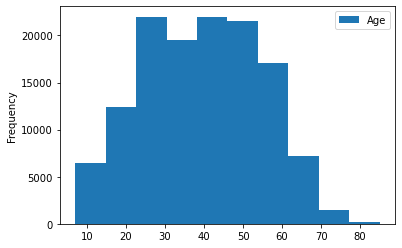

In [7]:
# this gives the exact count number of each age
age_count = df.groupby('Age').count().toPandas()

age_sample = df.select('Age').toPandas()
age_sample.plot.hist()
age_count.sort_values(by=['count'],ascending=False).head(10)

Interestingly, the age is fairly distributed and can be seen that most of the data points are coming from passengers aged between 20 to 50. Note that, this is not distinguished by anything.

Analyze age groups in different airline classes

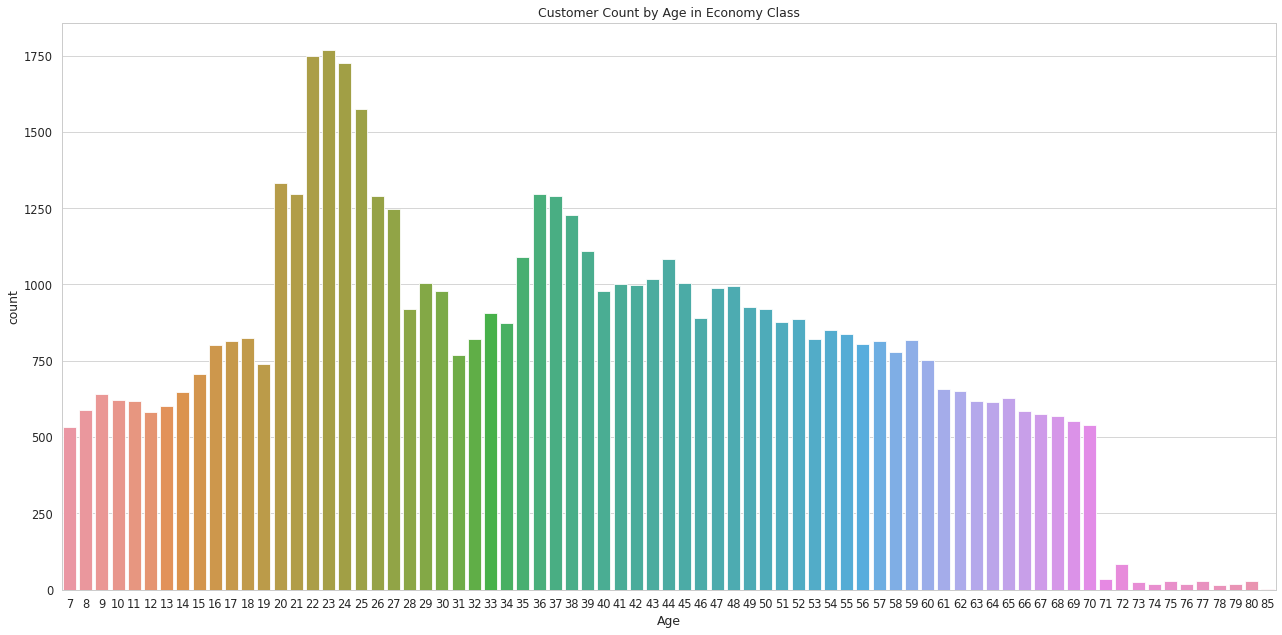

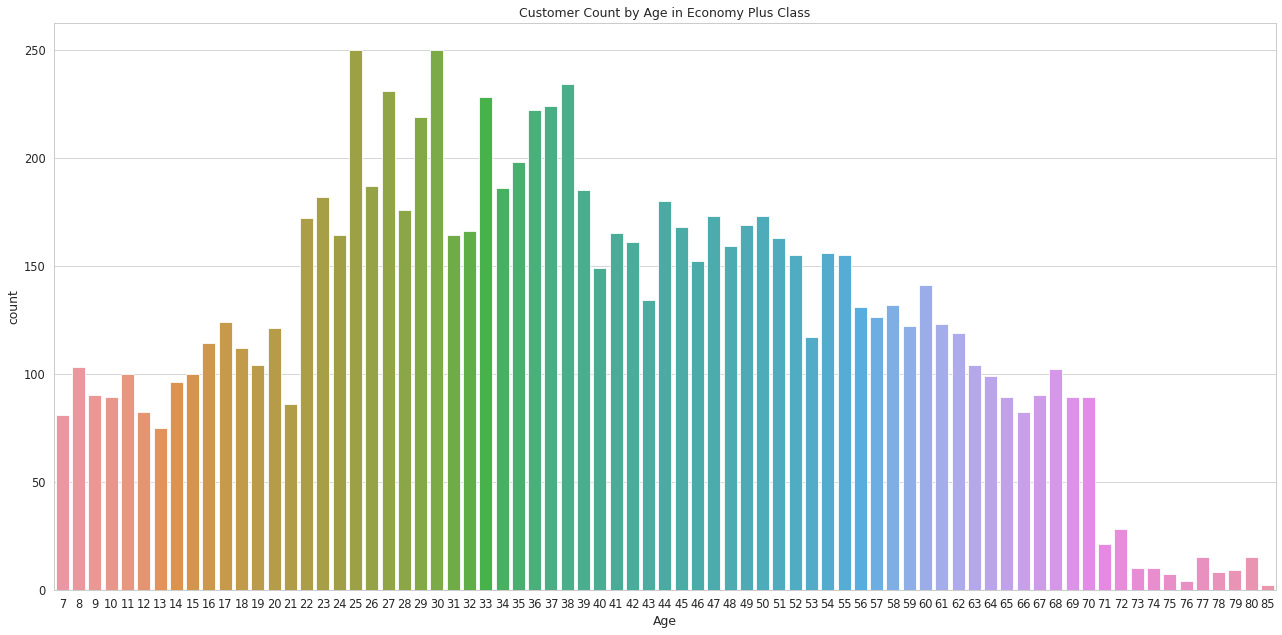

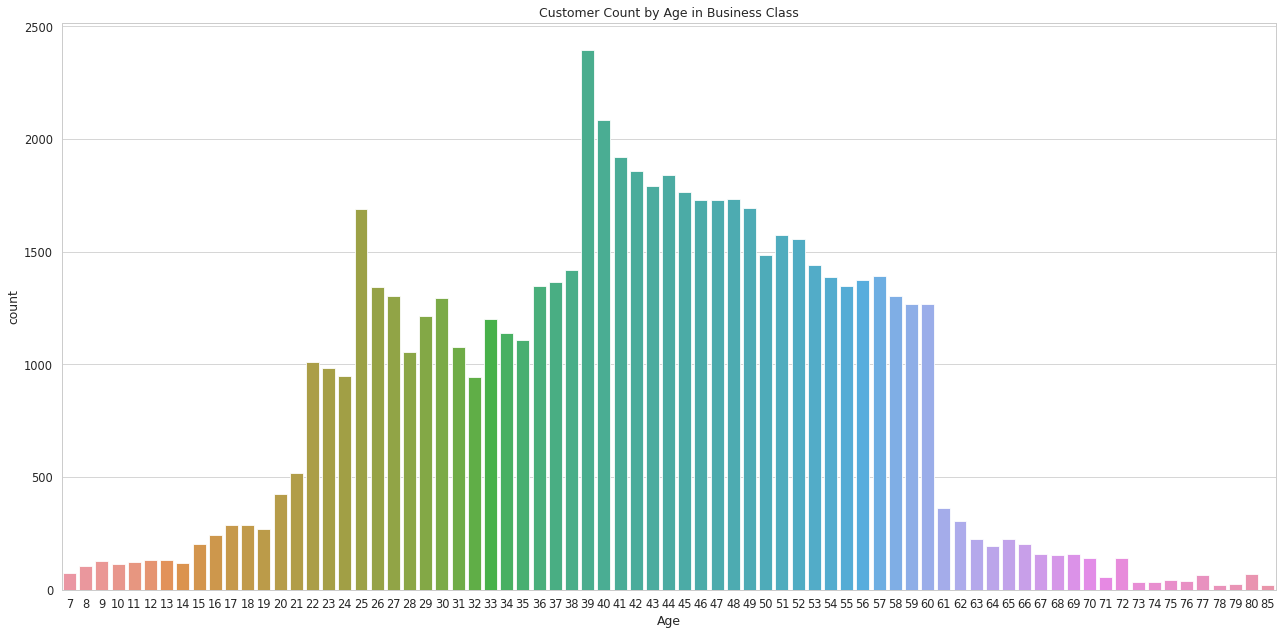

In [8]:
df_eco = pdDf[pdDf['Class']=='Eco']
df_eco1 = pdDf[pdDf['Class']=='Eco Plus']
df_bus = pdDf[pdDf['Class']=='Business']

# Show distribution graph each class by age (customer)
# for economy class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_eco,x='Age')
ax.set_title('Customer Count by Age in Economy Class')
plt.tight_layout()
plt.show()

# for economy plus class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_eco1,x='Age')
ax.set_title('Customer Count by Age in Economy Plus Class')
plt.tight_layout()
plt.show()

# for business class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_bus,x='Age')
ax.set_title('Customer Count by Age in Business Class')
plt.tight_layout()
plt.show()

In [9]:
print('Economy class sample size :',df_eco.shape[0])
print('Economy plus class sample size :',df_eco1.shape[0])
print('Business class sample size :',df_bus.shape[0])

Economy class sample size : 58309
Economy plus class sample size : 9411
Business class sample size : 62160


Notable observations. The economy class is dominated by passengers in the range 20-27 years while the business class is dominated by paseengers in range 39-49 years of age. Interestingly, the economy plus class is dominated by passengers in the age group of 22-39 years of age but it is the class that is the smallest in compared to the other 2 classes.

### Additional analysis

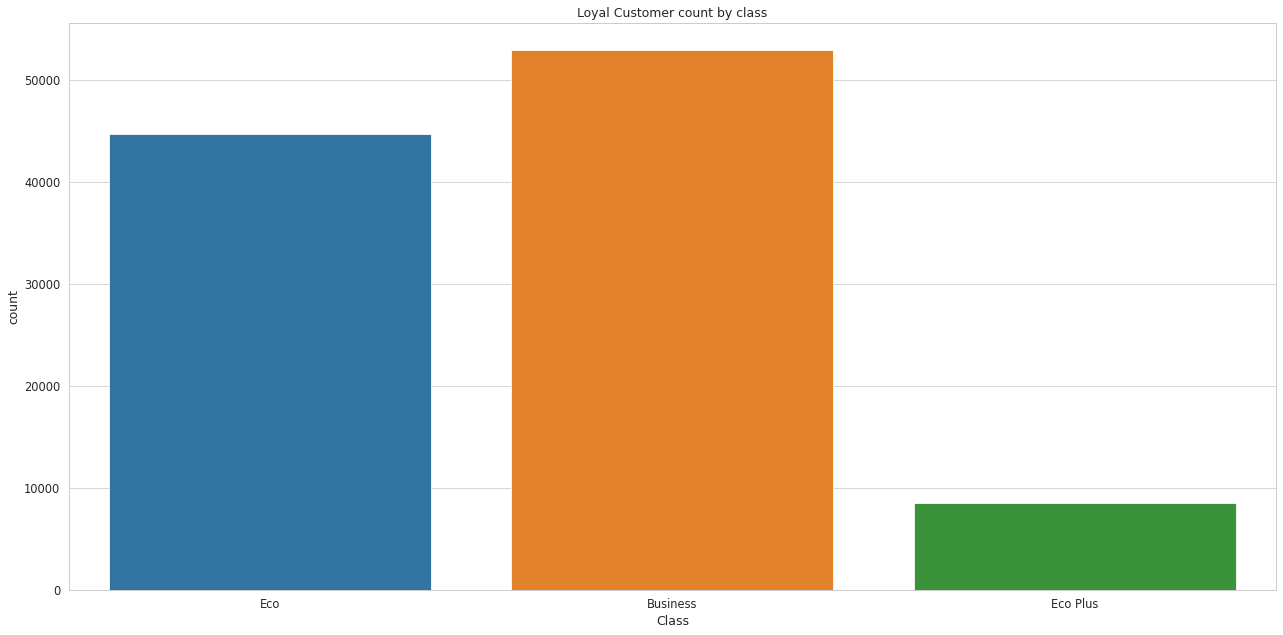

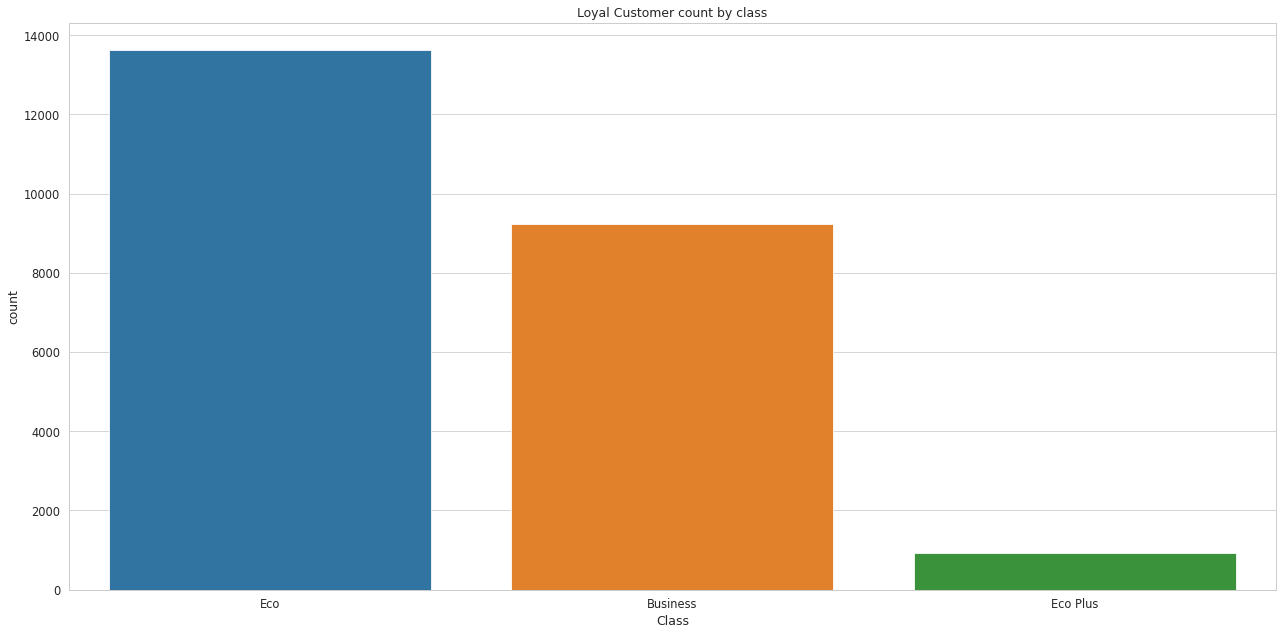

In [10]:
df_loyal_customers = pdDf[pdDf['Customer Type']=='Loyal Customer']
df_disloyal_customers = pdDf[pdDf['Customer Type']=='disloyal Customer']

# Distribution of class used by loyal customers
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_loyal_customers,x='Class')
ax.set_title('Loyal Customer count by class')
plt.tight_layout()
plt.show()

# Distribution of class used by disloyal customers
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_disloyal_customers,x='Class')
ax.set_title('Loyal Customer count by class')
plt.tight_layout()
plt.show()

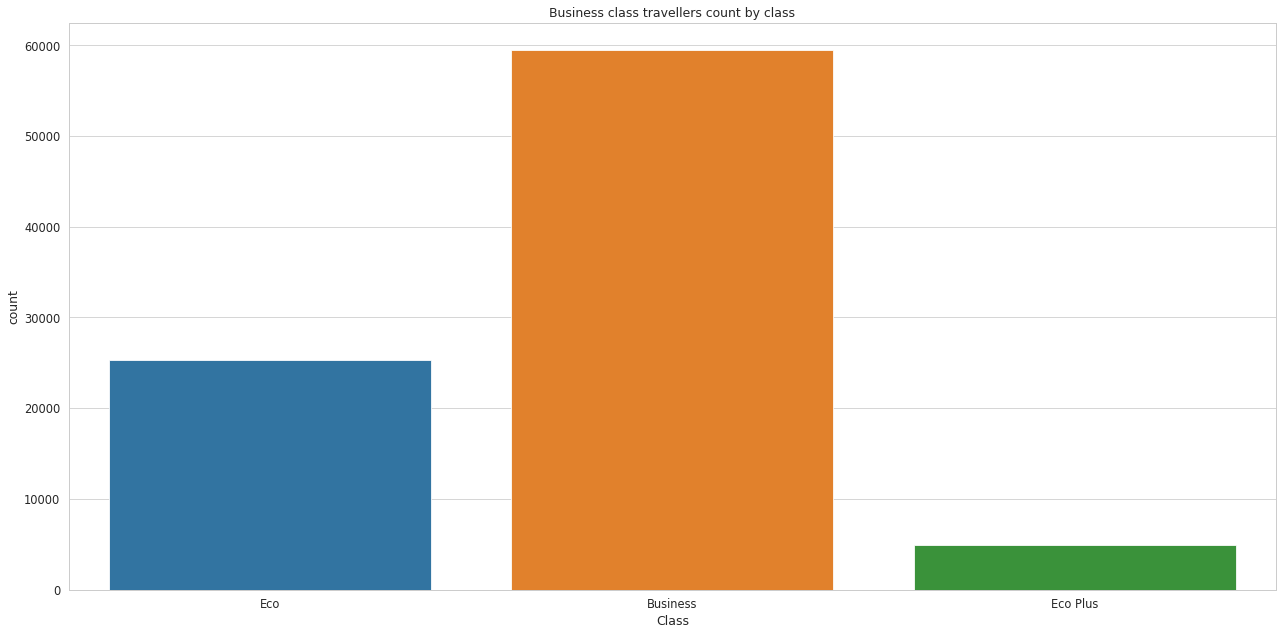

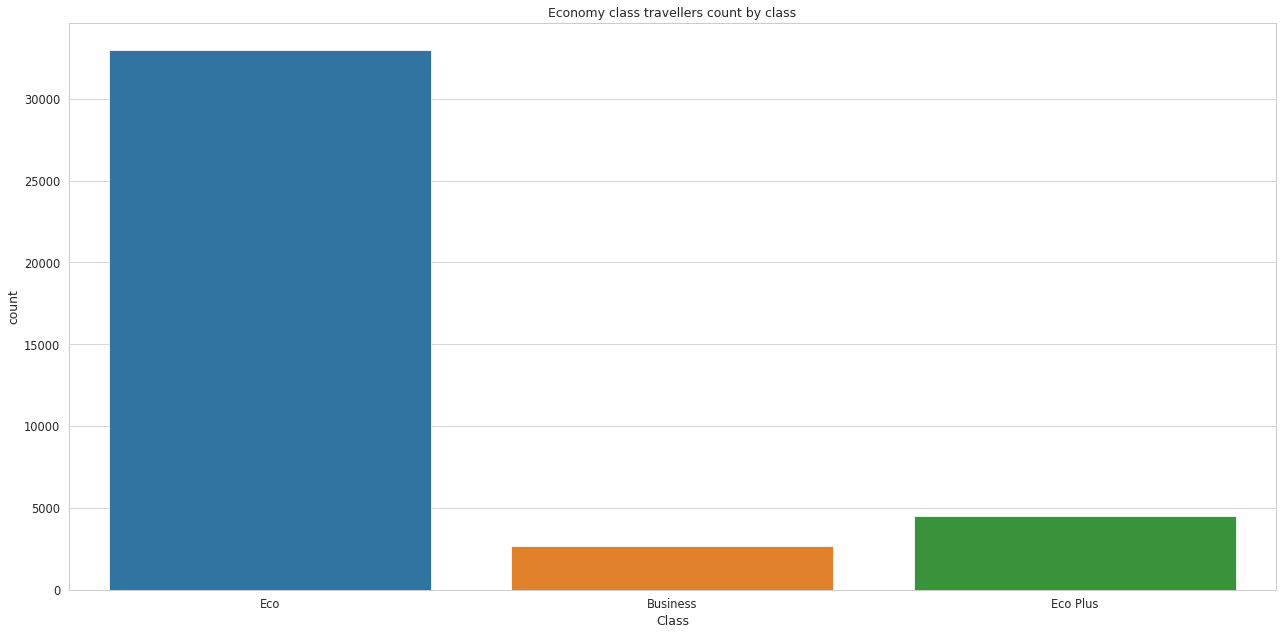

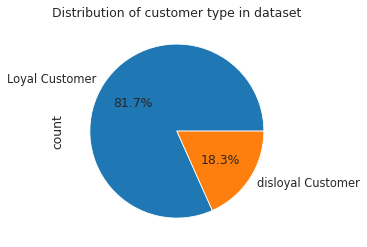

In [11]:
df_business_travellers = pdDf[pdDf['Type of Travel']=='Business travel']
df_personal_travellers = pdDf[pdDf['Type of Travel']=='Personal Travel']

# Distribution of travel type business by class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_business_travellers,x='Class')
ax.set_title('Business class travellers count by class')
plt.tight_layout()
plt.show()

# Distribution of travel type personal by class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_personal_travellers,x='Class')
ax.set_title('Economy class travellers count by class')
plt.tight_layout()
plt.show()

customer_type_stats = df.groupby('Customer Type').count().toPandas()
customer_type_stats.plot.pie(y='count', title='Distribution of customer type in dataset', labels=customer_type_stats['Customer Type'], legend=False, autopct='%1.1f%%')

Interesting observations - with 82% of the dataset consisting of customers which are loyal and of that 82%, it can be seen that loyal customers are more often then not using the business class. Whereas, disloyal customers are often using the economy class. Additionally, customers that are on business travel purpose would also oftenly utilize the business class whereas customers that are travelling for personal reasons would usually take the economy class.

In [12]:
pdDf = df.toPandas()
pdDf.sample(20)

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
61183,128204,satisfied,Male,disloyal Customer,51,Business travel,Business,1565,4,5,...,3,3,5,3,5,4,5,3,0,0.0
76313,87975,satisfied,Male,Loyal Customer,45,Business travel,Business,3266,1,1,...,4,2,2,2,2,4,2,4,0,0.0
109685,60219,satisfied,Male,Loyal Customer,28,Business travel,Business,3126,5,5,...,5,5,3,5,3,4,4,5,0,0.0
65007,29949,satisfied,Female,Loyal Customer,56,Business travel,Business,97,0,3,...,2,2,2,2,2,5,2,1,22,34.0
124741,62723,satisfied,Female,Loyal Customer,31,Business travel,Business,3767,2,2,...,5,5,3,5,4,3,5,5,0,0.0
58603,58160,satisfied,Male,disloyal Customer,29,Business travel,Business,2168,4,4,...,5,4,5,4,5,4,5,4,21,25.0
75277,80255,neutral or dissatisfied,Male,Loyal Customer,16,Business travel,Business,3883,2,1,...,2,2,2,4,3,3,4,2,0,4.0
68077,104903,neutral or dissatisfied,Male,Loyal Customer,23,Business travel,Business,2645,1,3,...,1,1,3,3,4,4,3,1,21,28.0
103317,111115,satisfied,Male,Loyal Customer,53,Business travel,Business,2969,1,1,...,4,4,4,4,4,3,4,3,39,17.0
28720,54021,neutral or dissatisfied,Male,Loyal Customer,31,Personal Travel,Eco,2863,3,5,...,4,3,5,3,4,1,4,3,84,78.0


## Correlations

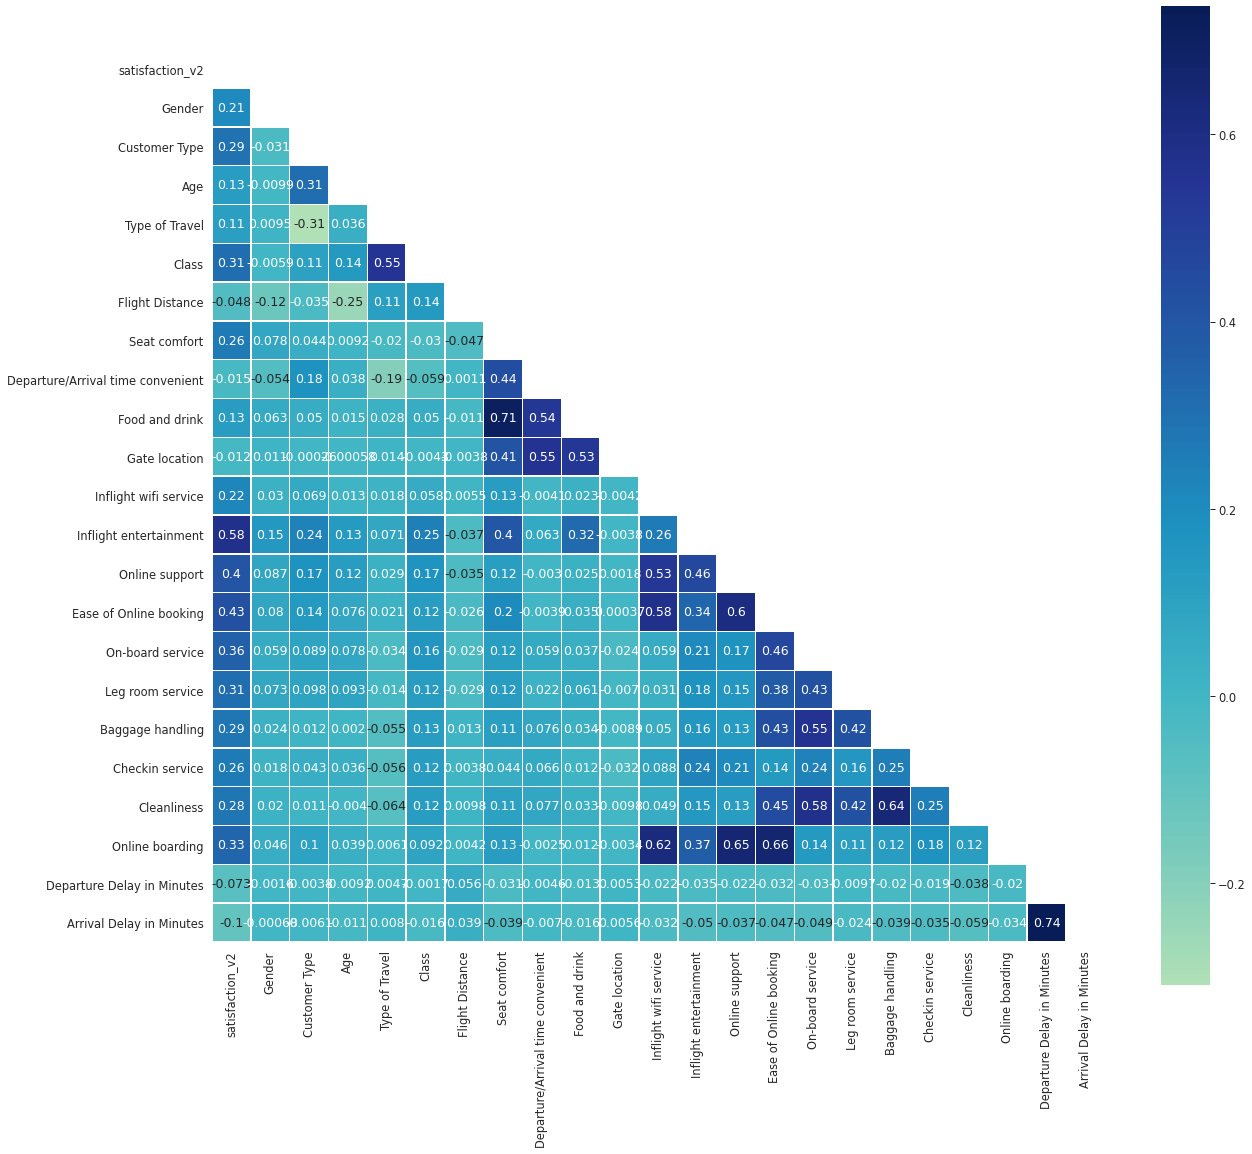

In [13]:
# the following functions are to transform strings to encoded values
# to be used to check correlation to satisfaction 
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1

# we drop id column because it is not useful for model training
# and encode all relevant columns and fill empty values in arrival
# delay in minutes
def process_data(df):
    df = df.drop(['id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction_v2'] = df['satisfaction_v2'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

processed_df = process_data(pdDf)

corr = processed_df.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

Based on the heat map correlation, it can be concluded that:
The best features are : Ease of Online Booking, Class and Type of Travel and
The worst features are : Gate location, Gender, and Departure/Arrival Time Convenient. We shall drop the features which are worst


In [14]:
processed_df = processed_df.drop('Gender', 1)
processed_df = processed_df.drop('Gate location', 1)
processed_df = processed_df.drop('Departure/Arrival time convenient', 1)

# before training model, will split train and test dataset and
# then normalize values

# features and target
features = ['Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Ease of Online booking',
       'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction_v2']

## Train ML Model


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve, precision_recall_curve, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold,cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import tree

In [18]:
# Getting x and y values to split for training and testing later on
y = processed_df['satisfaction_v2']
x = processed_df.drop('satisfaction_v2', 1)

# Split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print('Size of dataset for training',x_train['Age'].count())
print('Size of dataset for testing',x_test['Age'].count())

# Normalize Features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
X_train = scaler.fit_transform(x_train)
X_test = scaler.fit_transform(x_test)

Size of dataset for training 90916
Size of dataset for testing 38964


In [19]:
# Run models and output accuracy along with confusion matrix
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

### Random Forest

With GridSearch, best parameters can be found to be used as parameters when training Random Forest model

In [ ]:
parameter = {'max_depth' : [10,15,20,25,30,35], 
             'min_samples_split' : [0.001,0.0001,0.00001,0.000001], 
             'min_samples_leaf' : [0.001,0.0001,0.00001,0.000001]}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=101),parameter, cv=3, verbose=1)
grid_search_cv.fit(X_train,y_train)
grid_search_cv.best_params_

ROC_AUC = 0.9524779745499534
              precision    recall  f1-score   support

           0    0.93672   0.95802   0.94725     17554
           1    0.96492   0.94694   0.95585     21410

    accuracy                        0.95193     38964
   macro avg    0.95082   0.95248   0.95155     38964
weighted avg    0.95222   0.95193   0.95197     38964



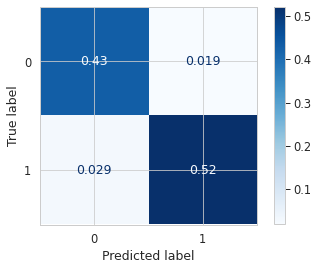

In [20]:
# doing grid search would have taken too long, instead. Via research
# following parameters are used

# now train model with best paramters and test for prediction
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_1 = RandomForestClassifier(**params_rf)

# get accuracy of model with function
model_1, roc_auc_rf = run_model(model_1, X_train, y_train, X_test, y_test)

### Logistic Regression

In [21]:
lr = LogisticRegression(random_state=0)
model_2 = lr.fit(X_train, y_train)

Let's observe the Beta Coefficient

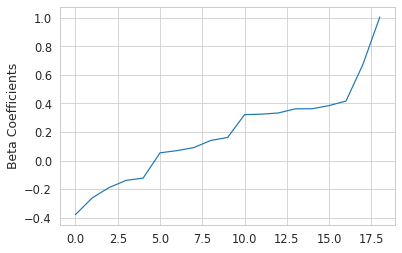

In [22]:
beta = np.sort(model_2.coef_)
plt.plot(beta[0])
plt.ylabel('Beta Coefficients')
plt.show()

Let us observe the ROC curves which plots the false positive rate against the true positive rate which tells us the summary of the skill of the model

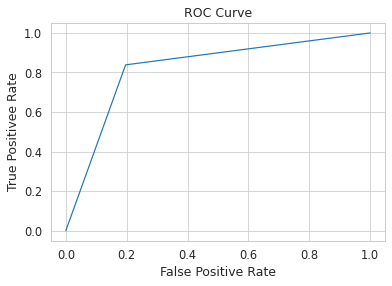

In [23]:
y_pred = model_2.predict(X_test) 
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positivee Rate')
plt.title('ROC Curve')
plt.show()

The number of points depend on the number of unique values in the input. Since the input vector has only 2 unique values, the function gives correct output. Which is why there are only 3 points.

Text(0, 0.5, 'True Positivee Rate')

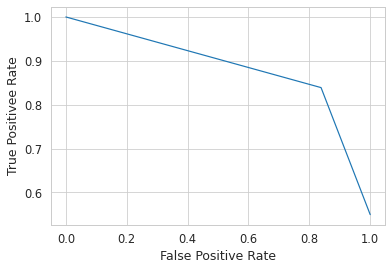

In [24]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(lr_recall, lr_precision)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positivee Rate')

ROC_AUC = 0.8210890773978973
              precision    recall  f1-score   support

           0    0.80314   0.80369   0.80342     17554
           1    0.83896   0.83849   0.83872     21410

    accuracy                        0.82281     38964
   macro avg    0.82105   0.82109   0.82107     38964
weighted avg    0.82282   0.82281   0.82282     38964



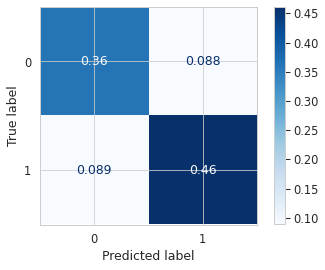

In [25]:
model_2, roc_auc_lr = run_model(model_2, X_train, y_train, X_test, y_test)

### Linear Regression

In [28]:
linear_r = LinearRegression()
model_3 = linear_r.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print('Coefficients :', model_2.coef_)
print('Mean squared error : %.2f'%mean_squared_error(y_test, y_pred))
print('Coefficiennt of determination: %.2f'%r2_score(y_test, y_pred))
roc_auc_l = roc_auc_score(y_test, y_pred)
print("ROC_AUC = {}".format(roc_auc_l))

Coefficients : [[ 0.67362412 -0.13846654  0.41711707  0.32512069 -0.18830249  0.36264232
  -0.37857556 -0.12296578  1.00614254  0.14083711  0.36300214  0.38527514
   0.32178079  0.09087052  0.33349599  0.05421104  0.16196217  0.06968823
  -0.26068989]]
Mean squared error : 0.18
Coefficiennt of determination: 0.28
ROC_AUC = 0.8210890773978973


### Decision Tree Classifier

[Text(669.6, 665.91, 'X[8] <= 0.084\ngini = 0.496\nsamples = 90916\nvalue = [41239, 49677]'),
 Text(334.8, 475.65, 'X[5] <= 0.477\ngini = 0.336\nsamples = 40676\nvalue = [31984, 8692]'),
 Text(167.4, 285.39, 'X[5] <= -1.681\ngini = 0.244\nsamples = 35570\nvalue = [30517, 5053]'),
 Text(83.7, 95.13, 'gini = 0.009\nsamples = 1811\nvalue = [8, 1803]'),
 Text(251.10000000000002, 95.13, 'gini = 0.174\nsamples = 33759\nvalue = [30509, 3250]'),
 Text(502.20000000000005, 285.39, 'X[5] <= 1.197\ngini = 0.41\nsamples = 5106\nvalue = [1467, 3639]'),
 Text(418.5, 95.13, 'gini = 0.49\nsamples = 3360\nvalue = [1439, 1921]'),
 Text(585.9, 95.13, 'gini = 0.032\nsamples = 1746\nvalue = [28, 1718]'),
 Text(1004.4000000000001, 475.65, 'X[10] <= 0.019\ngini = 0.301\nsamples = 50240\nvalue = [9255, 40985]'),
 Text(837.0, 285.39, 'X[8] <= 0.83\ngini = 0.486\nsamples = 13662\nvalue = [5679, 7983]'),
 Text(753.3000000000001, 95.13, 'gini = 0.496\nsamples = 9350\nvalue = [5100, 4250]'),
 Text(920.7, 95.13, 'gi

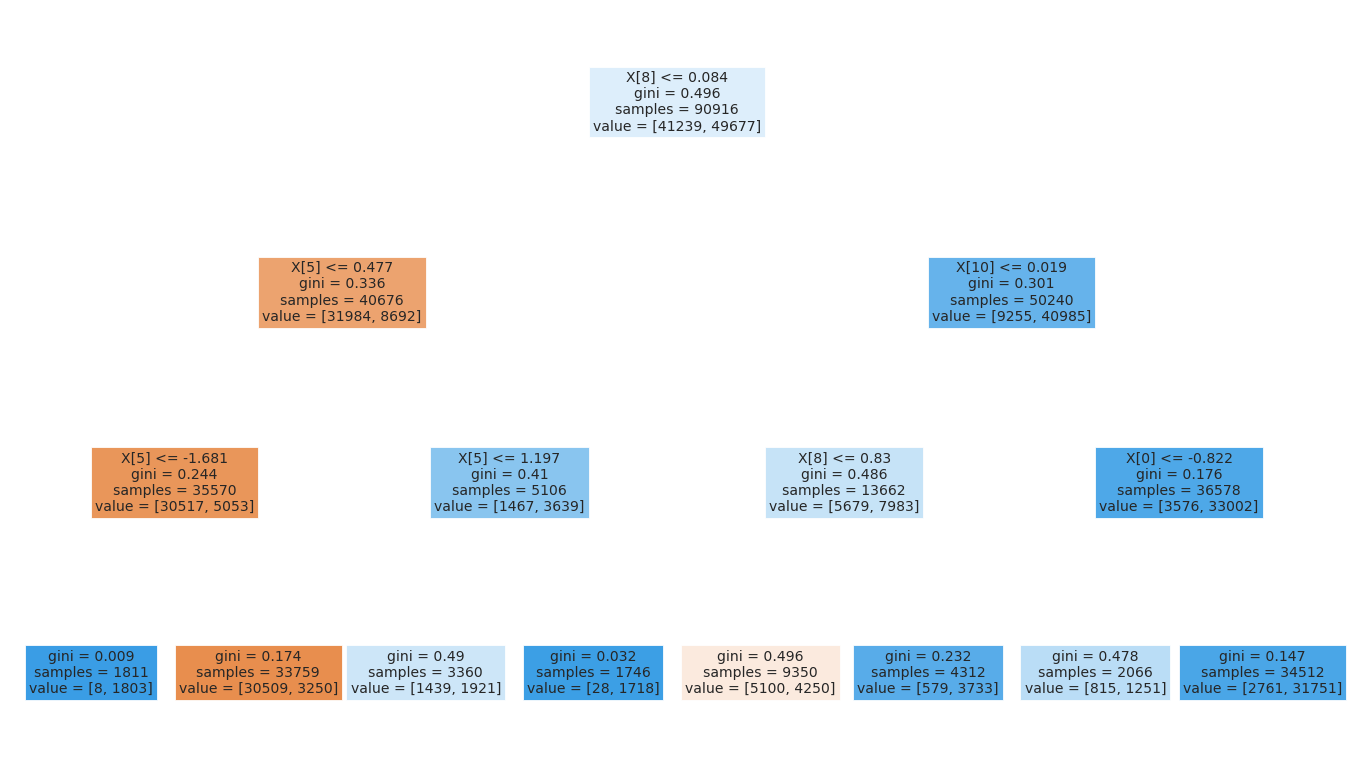

In [30]:
model_4 = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)
model_4.fit(X_train, y_train)

plt.figure(figsize=(24,14))
tree.plot_tree(model_4, filled=True, fontsize=14)

Above is a representation of how the model will continue to split nodes till all nodes are pure (samples with only one class). In this case, max dept is set to 3 so only 3 splits were done

ROC_AUC = 0.8535416463893865
              precision    recall  f1-score   support

           0    0.82046   0.86168   0.84057     17554
           1    0.88172   0.84540   0.86318     21410

    accuracy                        0.85274     38964
   macro avg    0.85109   0.85354   0.85187     38964
weighted avg    0.85412   0.85274   0.85299     38964



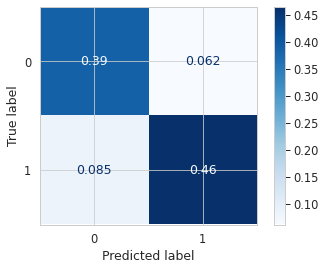

In [32]:
model_4, roc_auc_dt = run_model(model_4, X_train, y_train, X_test, y_test)

### Gradient Boosting

ROC_AUC = 0.9107304386751987
              precision    recall  f1-score   support

           0    0.89860   0.90521   0.90189     17554
           1    0.92181   0.91625   0.91902     21410

    accuracy                        0.91128     38964
   macro avg    0.91021   0.91073   0.91046     38964
weighted avg    0.91135   0.91128   0.91131     38964



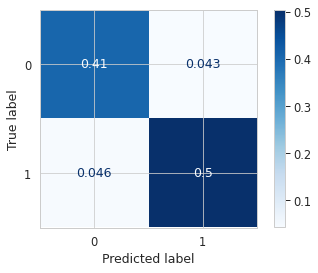

In [33]:
model_5 = GradientBoostingClassifier() # using default hyperparameters
model_5, roc_auc_gb = run_model(model_5, X_train, y_train, X_test, y_test)

Without the use of hypertuning the parameters, result obtained is 91% of accuracy, now let's try testing the best parameters to achieve better accuracy. As there are many hyperparameters to test, we shall mainly focus on exploring the following hyperparameters: number of trees, number of features used and the learning rate

##### Number of trees

>10 0.866 (0.003)
>50 0.902 (0.002)
>100 0.913 (0.002)
>500 0.937 (0.002)
>1000 0.943 (0.002)


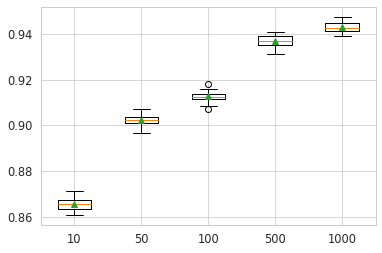

In [45]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000] 
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n)
    return models

# NOTE that we are splitting the original data to new train and test datasets
# we are only trying to investigate if this could in general improve the accuracy of the model
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_scaled, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Increasing accuracy trend with the nicrease of number of trees

#### Learning Rate

>0.0100 0.866 (0.003)
>1.0000 0.941 (0.002)


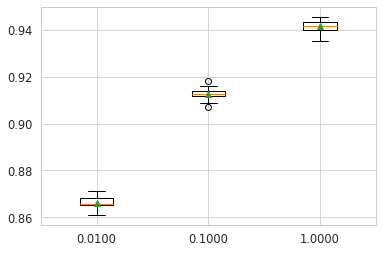

In [46]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define learning rates to explore
    for i in [0.01, 0.1, 1.0]:
        key = '%.4f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i)
    return models

models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_scaled, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Accuracy seem to be in an increasing trend with an increase in learning rate

#### Number of features

>1 0.895 (0.004)
>2 0.904 (0.002)
>3 0.907 (0.002)
>4 0.908 (0.002)
>5 0.909 (0.002)
>6 0.910 (0.002)
>7 0.910 (0.002)
>8 0.911 (0.002)
>9 0.911 (0.002)
>10 0.911 (0.002)
>11 0.911 (0.002)
>12 0.912 (0.002)
>13 0.912 (0.002)
>14 0.912 (0.002)
>15 0.912 (0.002)
>16 0.912 (0.002)
>17 0.912 (0.002)
>18 0.913 (0.002)
>19 0.913 (0.002)
>20 nan (nan)
>21 nan (nan)
>22 nan (nan)


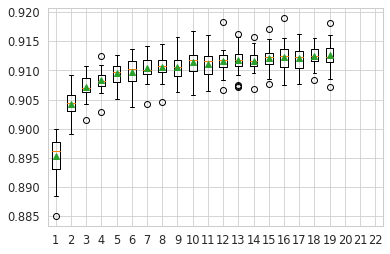

In [48]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore number of features from 1 to 23
    for i in range(1,23):
        models[str(i)] = GradientBoostingClassifier(max_features=i)
    return models

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_scaled, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Accuracy tend to increase but up to a certain extend - 12 features. So default value still remain. Ignore the nan values, forgot that I dropped some features that were not useful for model training

ROC_AUC = 0.922677061831545
              precision    recall  f1-score   support

           0    0.92803   0.90276   0.91522     17554
           1    0.92201   0.94260   0.93219     21410

    accuracy                        0.92465     38964
   macro avg    0.92502   0.92268   0.92370     38964
weighted avg    0.92472   0.92465   0.92454     38964



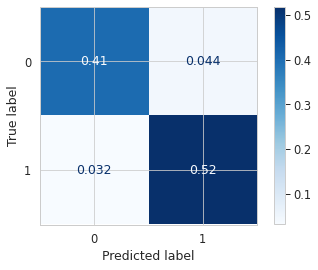

In [50]:
# now we use hyperparameters that are tuned
model_5 = GradientBoostingClassifier(max_depth=9, max_features=7, min_samples_leaf=60, learning_rate=0.001, n_estimators=1000   )
model_5, roc_auc_gb = run_model(model_5, X_train, y_train, X_test, y_test)

### Support Vector Machines

ROC_AUC = 0.939154078610942
              precision    recall  f1-score   support

           0    0.92322   0.94258   0.93280     17554
           1    0.95210   0.93573   0.94384     21410

    accuracy                        0.93882     38964
   macro avg    0.93766   0.93915   0.93832     38964
weighted avg    0.93909   0.93882   0.93887     38964



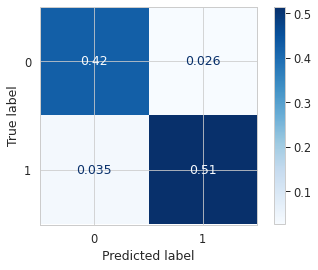

In [34]:
model_6 = SVC() # try using default hyperparameters
model_6, roc_auc_svc = run_model(model_6, X_train, y_train, X_test, y_test)

### K-Nearest Neighbors

ROC_AUC = 0.9172458381176184
              precision    recall  f1-score   support

           0    0.88172   0.93762   0.90881     17554
           1    0.94605   0.89687   0.92080     21410

    accuracy                        0.91523     38964
   macro avg    0.91388   0.91725   0.91481     38964
weighted avg    0.91707   0.91523   0.91540     38964



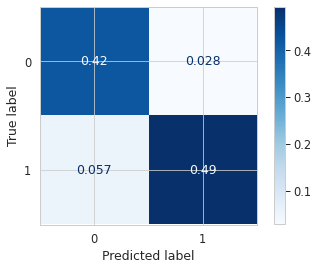

In [36]:
model_7 = KNeighborsClassifier(n_neighbors = 5)
model_7, roc_auc_knn = run_model(model_7, X_train, y_train, X_test, y_test)

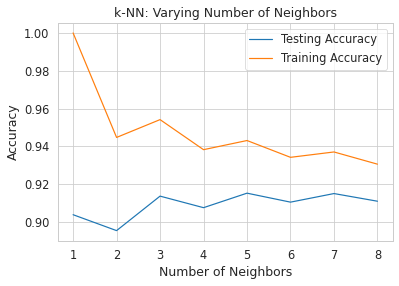

In [44]:
# lets test to see the best number of neighbor parameters that we can use
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Gaussian Naive Bayes

ROC_AUC = 0.8096839367807575
              precision    recall  f1-score   support

           0    0.79559   0.78466   0.79009     17554
           1    0.82541   0.83470   0.83003     21410

    accuracy                        0.81216     38964
   macro avg    0.81050   0.80968   0.81006     38964
weighted avg    0.81198   0.81216   0.81204     38964



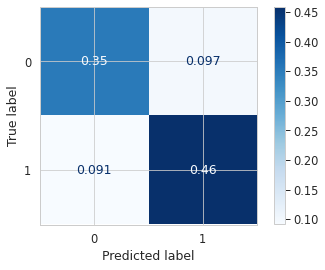

In [37]:
model_8 = GaussianNB()
model_8, roc_auc_gnb = run_model(model_8, X_train, y_train, X_test, y_test)

# Conclusion


 The best features are : Ease of Online Booking, Class and Type of Travel and
The worst features are : Gate location, Gender, and Departure/Arrival Time Convenient.

In [51]:
auc_scores = [roc_auc_rf, roc_auc_lr, roc_auc_l, 
              roc_auc_dt, roc_auc_gb, roc_auc_svc, 
              roc_auc_knn, roc_auc_gnb]
model_scores = pd.DataFrame(auc_scores, index=['Random Forest','Logistic Regression','Linear Regression',
                                               'Decision Tree', 'Gradient Boost', 'Support Vector Machines',
                                              'K-Nearest Neighbors', 'Gaussian Naive Bayes'], columns=['AUC'])
model_scores.head(10)


,AUC
Random Forest,0.952478
Logistic Regression,0.821089
Linear Regression,0.821089
Decision Tree,0.853542
Gradient Boost,0.922677
Support Vector Machines,0.939154
K-Nearest Neighbors,0.917246
Gaussian Naive Bayes,0.809684
